ID:2022-1-60-319

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import stats

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


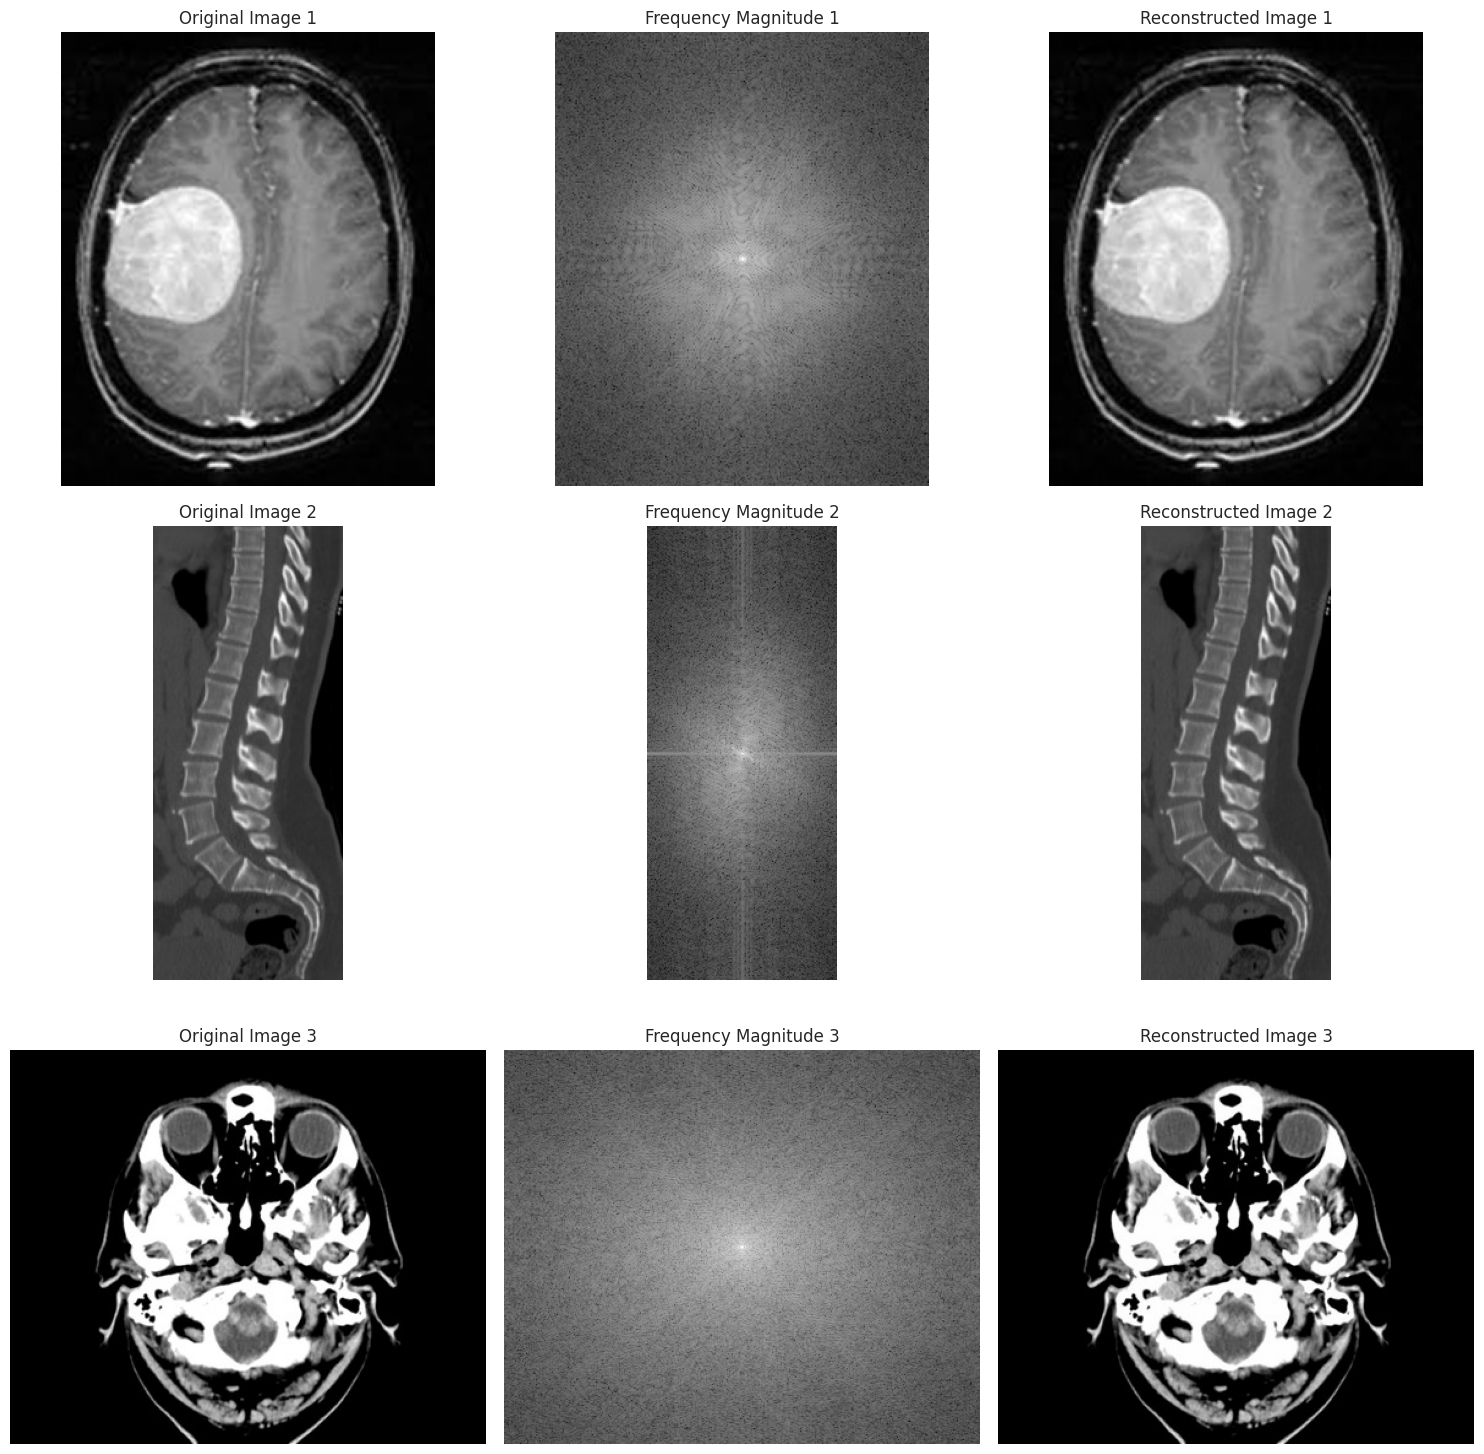

In [14]:
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Mount Google Drive (if not already done)
drive.mount('/content/drive')

# Image paths (replace with your actual images)
image_paths = [
    '/content/drive/MyDrive/cse438/lab_05/Picture1.jpg',
    '/content/drive/MyDrive/cse438/lab_05/Picture2.jpg',
    '/content/drive/MyDrive/cse438/lab_05/Picture3.jpg'
]

def load_image_gray(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    img = cv2.imread(path, 0)  # Load grayscale
    if img is None:
        raise ValueError(f"Failed to load image at {path}")
    return img

def apply_fft(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    return fshift, magnitude_spectrum

def apply_ifft(fshift):
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    return img_back.astype(np.uint8)

def show_results(imgs, mags, recon_imgs):
    n = len(imgs)
    plt.figure(figsize=(15, 5 * n))
    for i in range(n):
        plt.subplot(n, 3, i*3 + 1)
        plt.imshow(imgs[i], cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 2)
        plt.imshow(mags[i], cmap='gray')
        plt.title(f"Frequency Magnitude {i+1}")
        plt.axis('off')

        plt.subplot(n, 3, i*3 + 3)
        plt.imshow(recon_imgs[i], cmap='gray')
        plt.title(f"Reconstructed Image {i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


imgs = [load_image_gray(p) for p in image_paths]


fshifts, mags = zip(*[apply_fft(img) for img in imgs])


recon_imgs = [apply_ifft(fshift) for fshift in fshifts]


show_results(imgs, mags, recon_imgs)



Processing: /content/drive/MyDrive/cse438/lab_05/Picture1.jpg
DCT: CR = 106.80, PSNR = 30.23 dB
Haar: CR = 1.66, PSNR = 29.27 dB
DCT-Haar: CR = 1.33, PSNR = 33.36 dB


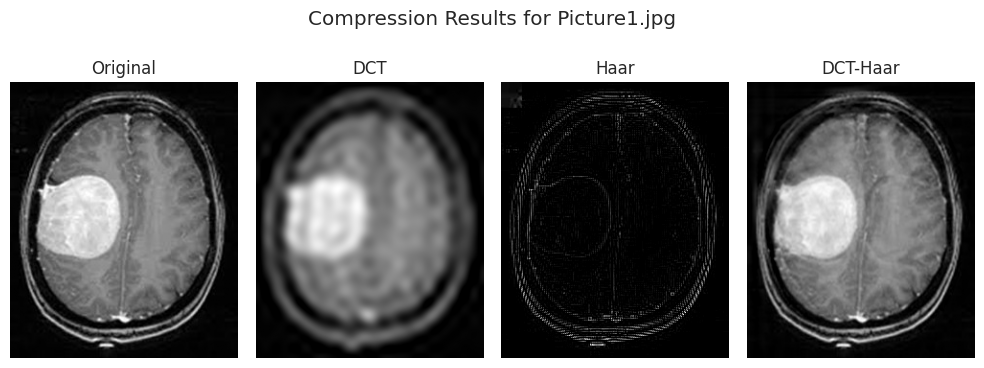


Processing: /content/drive/MyDrive/cse438/lab_05/Picture2.jpg
DCT: CR = 104.29, PSNR = 30.15 dB
Haar: CR = 1.60, PSNR = 28.44 dB
DCT-Haar: CR = 1.33, PSNR = 33.25 dB


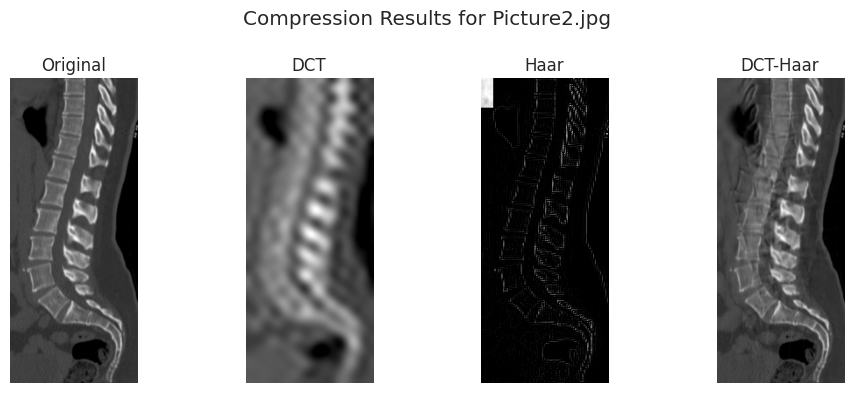


Processing: /content/drive/MyDrive/cse438/lab_05/Picture3.jpg
DCT: CR = 103.01, PSNR = 31.31 dB
Haar: CR = 3.27, PSNR = 33.59 dB
DCT-Haar: CR = 1.33, PSNR = 33.11 dB


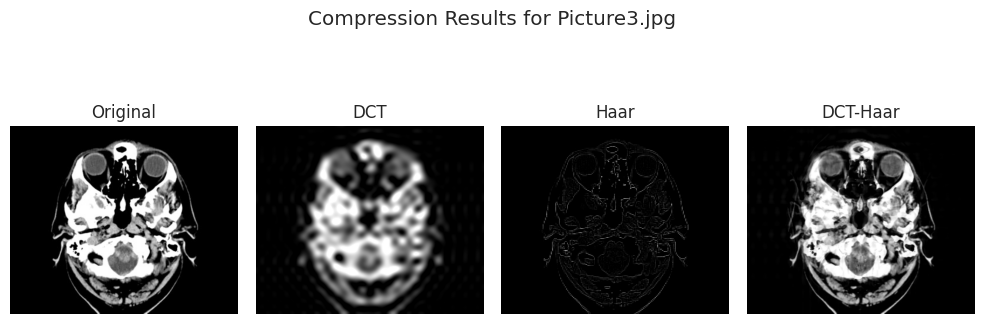

In [7]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from math import log10


def psnr(original, compressed):

    if original.shape != compressed.shape:
        compressed = cv2.resize(compressed, (original.shape[1], original.shape[0]))
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    return 20 * log10(255.0 / np.sqrt(mse))

def compression_ratio(original_size, compressed_nonzero):
    return original_size / compressed_nonzero


def dct_compression(img, keep_fraction=0.1):
    img_float = np.float32(img)
    dct_img = cv2.dct(img_float)
    h, w = dct_img.shape
    mask = np.zeros((h, w))
    mask[:int(h*keep_fraction), :int(w*keep_fraction)] = 1
    dct_img *= mask
    compressed = cv2.idct(dct_img)
    compressed = cv2.resize(compressed, (img.shape[1], img.shape[0]))
    nonzero_count = np.count_nonzero(dct_img)
    return np.uint8(np.clip(compressed, 0, 255)), nonzero_count


def haar_compression(img, keep_fraction=0.1):
    coeffs2 = pywt.dwt2(img, 'haar')
    cA, (cH, cV, cD) = coeffs2
    h, w = cA.shape
    cA[int(h*keep_fraction):, :] = 0
    cA[:, int(w*keep_fraction):] = 0
    compressed = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    compressed = cv2.resize(compressed, (img.shape[1], img.shape[0]))
    nonzero_count = np.count_nonzero(cA) + np.count_nonzero(cH) + np.count_nonzero(cV) + np.count_nonzero(cD)
    return np.uint8(np.clip(compressed, 0, 255)), nonzero_count


def dct_haar_compression(img, keep_fraction=0.1):
    dct_img = cv2.dct(np.float32(img))
    haar_img, (cH, cV, cD) = pywt.dwt2(dct_img, 'haar')
    h, w = haar_img.shape
    haar_img[int(h*keep_fraction):, :] = 0
    haar_img[:, int(w*keep_fraction):] = 0
    reconstructed_dct = pywt.idwt2((haar_img, (cH, cV, cD)), 'haar')
    compressed = cv2.idct(reconstructed_dct)
    compressed = cv2.resize(compressed, (img.shape[1], img.shape[0]))
    nonzero_count = np.count_nonzero(haar_img) + np.count_nonzero(cH) + np.count_nonzero(cV) + np.count_nonzero(cD)
    return np.uint8(np.clip(compressed, 0, 255)), nonzero_count


image_paths = [
    "/content/drive/MyDrive/cse438/lab_05/Picture1.jpg",
    "/content/drive/MyDrive/cse438/lab_05/Picture2.jpg",
    "/content/drive/MyDrive/cse438/lab_05/Picture3.jpg"
]

for path in image_paths:
    print(f"\nProcessing: {path}")

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    original_size = img.size


    dct_img, dct_nonzero = dct_compression(img)
    haar_img, haar_nonzero = haar_compression(img)
    dct_haar_img, dct_haar_nonzero = dct_haar_compression(img)


    methods = [
        ("DCT", dct_img, dct_nonzero),
        ("Haar", haar_img, haar_nonzero),
        ("DCT-Haar", dct_haar_img, dct_haar_nonzero)
    ]

    for name, comp_img, nonzero in methods:
        cr = compression_ratio(original_size, nonzero)
        p = psnr(img, comp_img)
        print(f"{name}: CR = {cr:.2f}, PSNR = {p:.2f} dB")


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(dct_img, cmap='gray')
    plt.title('DCT')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(haar_img, cmap='gray')
    plt.title('Haar')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(dct_haar_img, cmap='gray')
    plt.title('DCT-Haar')
    plt.axis('off')

    plt.suptitle(f"Compression Results for {path.split('/')[-1]}")
    plt.tight_layout()
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image loaded successfully with shape: (376, 376)


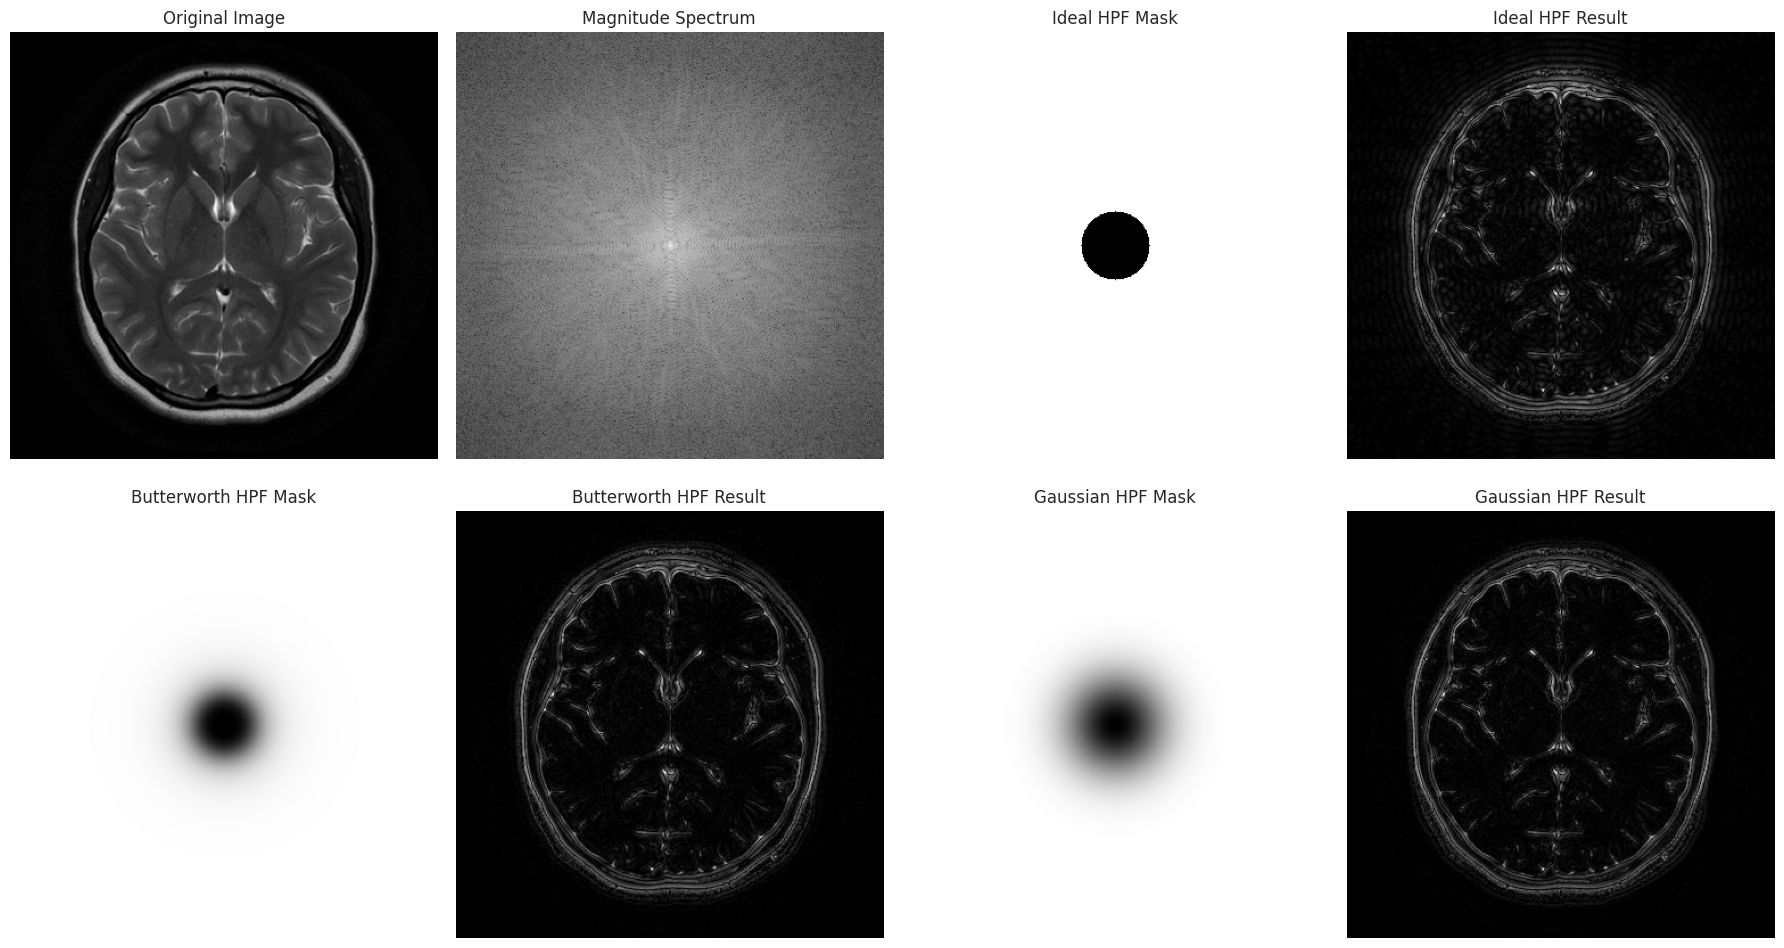

In [12]:
image_path = '/content/drive/MyDrive/cse438/lab_05/Picture4.jpg'


if not os.path.exists(image_path):
    raise FileNotFoundError(f"File does not exist at: {image_path}")


img = cv2.imread(image_path, 0)
if img is None:
    raise ValueError("Failed to load image. Check the image path or file.")

print(f"Image loaded successfully with shape: {img.shape}")


def show_images(images, titles, figsize=(18, 10)):
    plt.figure(figsize=figsize)
    n = len(images)
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, (n + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)  # +1 to avoid log(0)


rows, cols = img.shape
crow, ccol = rows // 2, cols // 2

def ideal_hpf(shape, cutoff):
    mask = np.ones(shape, np.uint8)
    x, y = np.ogrid[:shape[0], :shape[1]]
    mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= cutoff * cutoff
    mask[mask_area] = 0
    return mask

def butterworth_hpf(shape, cutoff, order):
    x, y = np.ogrid[:shape[0], :shape[1]]
    distance = np.sqrt((x - crow) ** 2 + (y - ccol) ** 2)

    epsilon = 1e-6
    mask = 1 / (1 + (cutoff / (distance + epsilon)) ** (2 * order))
    return mask

def gaussian_hpf(shape, cutoff):
    x, y = np.ogrid[:shape[0], :shape[1]]
    distance_squared = (x - crow) ** 2 + (y - ccol) ** 2
    mask = 1 - np.exp(-distance_squared / (2 * (cutoff ** 2)))
    return mask

cutoff = 30
order = 2

ideal_mask = ideal_hpf(img.shape, cutoff)
butter_mask = butterworth_hpf(img.shape, cutoff, order)
gauss_mask = gaussian_hpf(img.shape, cutoff)


f_ideal = fshift * ideal_mask
f_butter = fshift * butter_mask
f_gauss = fshift * gauss_mask


def ifft_image(fshift_filtered):
    img_back = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(img_back)
    img_back = np.abs(img_back)

    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    return img_back.astype(np.uint8)

img_ideal = ifft_image(f_ideal)
img_butter = ifft_image(f_butter)
img_gauss = ifft_image(f_gauss)


show_images(
    [img, magnitude_spectrum,
     ideal_mask * 255, img_ideal,
     butter_mask * 255, img_butter,
     gauss_mask * 255, img_gauss],
    ['Original Image', 'Magnitude Spectrum',
     'Ideal HPF Mask', 'Ideal HPF Result',
     'Butterworth HPF Mask', 'Butterworth HPF Result',
     'Gaussian HPF Mask', 'Gaussian HPF Result']
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image shape: (376, 376)


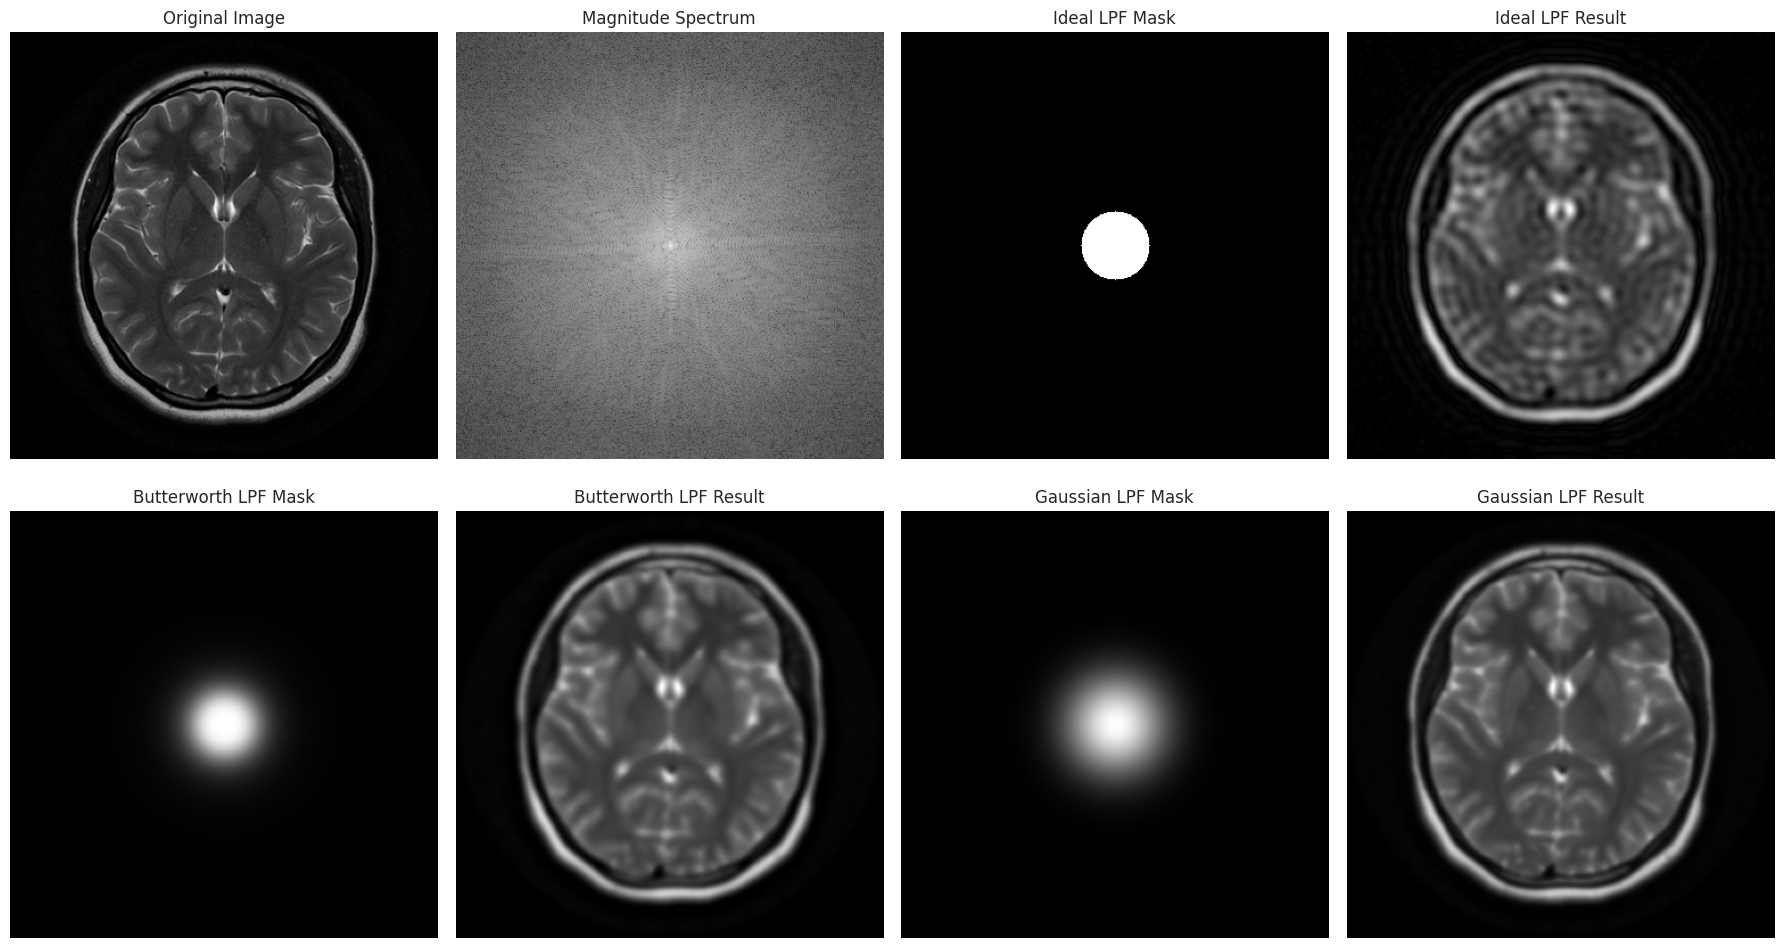

In [13]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


image_path = '/content/drive/MyDrive/cse438/lab_05/Picture4.jpg'
if not os.path.exists(image_path):
    raise FileNotFoundError(f"File not found: {image_path}")

img = cv2.imread(image_path, 0)
if img is None:
    raise ValueError("Failed to load image.")

print(f"Image shape: {img.shape}")

def show_images(images, titles, figsize=(18, 10)):
    plt.figure(figsize=figsize)
    n = len(images)
    for i, (img, title) in enumerate(zip(images, titles), 1):
        plt.subplot(2, (n + 1) // 2, i)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

rows, cols = img.shape
crow, ccol = rows // 2, cols // 2


def ideal_lpf(shape, cutoff):
    mask = np.zeros(shape, np.uint8)
    x, y = np.ogrid[:shape[0], :shape[1]]
    mask_area = (x - crow) ** 2 + (y - ccol) ** 2 <= cutoff ** 2
    mask[mask_area] = 1
    return mask


def butterworth_lpf(shape, cutoff, order):
    x, y = np.ogrid[:shape[0], :shape[1]]
    distance = np.sqrt((x - crow) ** 2 + (y - ccol) ** 2)
    epsilon = 1e-6
    mask = 1 / (1 + (distance / (cutoff + epsilon)) ** (2 * order))
    return mask


def gaussian_lpf(shape, cutoff):
    x, y = np.ogrid[:shape[0], :shape[1]]
    distance_squared = (x - crow) ** 2 + (y - ccol) ** 2
    mask = np.exp(-distance_squared / (2 * (cutoff ** 2)))
    return mask

cutoff = 30
order = 2

ideal_mask = ideal_lpf(img.shape, cutoff)
butter_mask = butterworth_lpf(img.shape, cutoff, order)
gauss_mask = gaussian_lpf(img.shape, cutoff)


f_ideal = fshift * ideal_mask
f_butter = fshift * butter_mask
f_gauss = fshift * gauss_mask


def ifft_image(fshift_filtered):
    img_back = np.fft.ifftshift(fshift_filtered)
    img_back = np.fft.ifft2(img_back)
    img_back = np.abs(img_back)
    img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
    return img_back.astype(np.uint8)

img_ideal = ifft_image(f_ideal)
img_butter = ifft_image(f_butter)
img_gauss = ifft_image(f_gauss)


show_images(
    [img, magnitude_spectrum,
     ideal_mask * 255, img_ideal,
     butter_mask * 255, img_butter,
     gauss_mask * 255, img_gauss],
    ['Original Image', 'Magnitude Spectrum',
     'Ideal LPF Mask', 'Ideal LPF Result',
     'Butterworth LPF Mask', 'Butterworth LPF Result',
     'Gaussian LPF Mask', 'Gaussian LPF Result']
)
